In [1]:
import numpy as np
import itertools
import json

from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve, _SigmoidCalibration, _sigmoid_calibration
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score, generate_corruptions_for_eval
from sklearn.metrics import brier_score_loss, log_loss
from scipy.special import expit

from ampligraph.datasets import load_fb15k_237
from ampligraph.latent_features.models import TransE, ComplEx

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [4]:
X = load_fb15k_237()

In [5]:
import types
from functools import partial
import tensorflow as tf
from sklearn.utils import check_random_state
from tqdm import tqdm
from ampligraph.datasets import AmpligraphDatasetAdapter, NumpyDatasetAdapter
from ampligraph.evaluation import generate_corruptions_for_fit, to_idx, generate_corruptions_for_eval, \
    hits_at_n_score, mrr_score


def generate_corruptions_triples(self, X_pos, batches_count, epochs):
    try:
        tf.reset_default_graph()
        self.rnd = check_random_state(self.seed)
        tf.random.set_random_seed(self.seed)

        self._load_model_from_trained_params()

        dataset_handle = NumpyDatasetAdapter()
        dataset_handle.use_mappings(self.rel_to_idx, self.ent_to_idx)

        dataset_handle.set_data(X_pos, "pos")

        batch_size_pos = int(np.ceil(dataset_handle.get_size("pos") / batches_count))

        gen_fn = partial(dataset_handle.get_next_train_batch, batch_size=batch_size_pos, dataset_type="pos")
        dataset = tf.data.Dataset.from_generator(gen_fn,
                                                 output_types=tf.int32,
                                                 output_shapes=(None, 3))
        dataset = dataset.repeat().prefetch(1)
        dataset_iter = tf.data.make_one_shot_iterator(dataset)

        x_pos_tf = dataset_iter.get_next()

        e_s, e_p, e_o = self._lookup_embeddings(x_pos_tf)
        scores_pos = self._fn(e_s, e_p, e_o)

        x_neg_tf = generate_corruptions_for_fit(x_pos_tf,
                                                entities_list=None,
                                                eta=1,
                                                corrupt_side='s+o',
                                                entities_size=0,
                                                rnd=self.seed)

        epoch_iterator_with_progress = tqdm(range(1, epochs + 1), disable=(not self.verbose), unit='epoch')

        scores_list = []
        with tf.Session(config=self.tf_config) as sess:
            sess.run(tf.global_variables_initializer())
            for _ in epoch_iterator_with_progress:
                losses = []
                for batch in range(batches_count):
                    scores_list.append(sess.run(x_neg_tf))

        dataset_handle.cleanup()
        return np.concatenate(scores_list)
    
    except Exception as e:
        dataset_handle.cleanup()
        

def generate_corruptions(self, X_pos, batches_count, epochs):
    try:
        tf.reset_default_graph()
        self.rnd = check_random_state(self.seed)
        tf.random.set_random_seed(self.seed)

        self._load_model_from_trained_params()

        dataset_handle = NumpyDatasetAdapter()
        dataset_handle.use_mappings(self.rel_to_idx, self.ent_to_idx)

        dataset_handle.set_data(X_pos, "pos")

        batch_size_pos = int(np.ceil(dataset_handle.get_size("pos") / batches_count))

        gen_fn = partial(dataset_handle.get_next_train_batch, batch_size=batch_size_pos, dataset_type="pos")
        dataset = tf.data.Dataset.from_generator(gen_fn,
                                                 output_types=tf.int32,
                                                 output_shapes=(None, 3))
        dataset = dataset.repeat().prefetch(1)
        dataset_iter = tf.data.make_one_shot_iterator(dataset)

        x_pos_tf = dataset_iter.get_next()

        e_s, e_p, e_o = self._lookup_embeddings(x_pos_tf)
        scores_pos = self._fn(e_s, e_p, e_o)

        x_neg_tf = generate_corruptions_for_fit(x_pos_tf,
                                                entities_list=None,
                                                eta=1,
                                                corrupt_side='s+o',
                                                entities_size=0,
                                                rnd=self.seed)

        e_s_neg, e_p_neg, e_o_neg = self._lookup_embeddings(x_neg_tf)
        scores = self._fn(e_s_neg, e_p_neg, e_o_neg)

        epoch_iterator_with_progress = tqdm(range(1, epochs + 1), disable=(not self.verbose), unit='epoch')

        scores_list = []
        with tf.Session(config=self.tf_config) as sess:
            sess.run(tf.global_variables_initializer())
            for _ in epoch_iterator_with_progress:
                losses = []
                for batch in range(batches_count):
                    scores_list.append(sess.run(scores))

        dataset_handle.cleanup()
        return np.concatenate(scores_list)
    
    except Exception as e:
        dataset_handle.cleanup()
        raise e

In [6]:
def pos_iso(cal_model, pos_scores, neg_scores, positive_base_rate):
    weigths_pos = len(neg_scores) / len(pos_scores)
    weights_neg = (1.0 - positive_base_rate) / positive_base_rate
    weights = np.concatenate((np.full(pos_scores.shape, weigths_pos),
                              np.full(neg_scores.shape, weights_neg))).astype(float)
    target =  np.concatenate((np.ones(pos_scores.shape), np.zeros(neg_scores.shape))).astype(float)
    x = np.concatenate((pos_scores, neg_scores)).astype(float)
    
    cal_model.fit(x, target, sample_weight=weights)
    return cal_model

In [7]:
model = ComplEx(batches_count=64, seed=0, epochs=500, k=350, eta=30,
                optimizer='adam', optimizer_params={'lr':0.00005},
                regularizer='LP', regularizer_params={'lambda': 0.0001},
                loss='multiclass_nll', verbose=True)

filter_triples = np.concatenate((X['train'], X['valid'], X['test']))

model.fit(X['train'], False)

WARNING - From /home/ptabacof/.conda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
WARNING - From /home/ptabacof/.conda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:429: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
WARNING - From /home/ptabacof/.

Average Loss:   0.206223: 100%|██████████| 500/500 [44:44<00:00,  4.84s/epoch]


In [8]:
ranks = evaluate_performance(X['test'], 
                             model=model, 
                             filter_triples=filter_triples,
                             use_default_protocol=True, 
                             verbose=False)

100%|██████████| 20438/20438 [02:42<00:00, 125.93it/s]


In [9]:
mrr_score(ranks),  hits_at_n_score(ranks, n=10), mr_score(ranks)

(0.3203637768277881, 0.4987767883354536, 182.66491339661414)

In [10]:
model.generate_corruptions_triples = types.MethodType(generate_corruptions_triples, model)
fake_negatives = model.generate_corruptions_triples(X['test'], batches_count=10, epochs=1000)

WARNING - From /home/ptabacof/AmpliGraph-Lab/ampligraph/evaluation/protocol.py:348: multinomial (from tensorflow.python.ops.random_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.random.categorical instead.


100%|██████████| 1000/1000 [00:27<00:00, 36.00epoch/s]


In [11]:
idx_to_ent = {v: k for k, v in model.ent_to_idx.items()} 
idx_to_rel = {v: k for k, v in model.rel_to_idx.items()} 

In [ ]:
results = []
                                        
for pbr in np.linspace(0.05, 0.95, 19):

    fake_idx = np.random.randint(len(fake_negatives), size=int(len(X['test'])/pbr-len(X['test'])))
    fake_test = fake_negatives[fake_idx, :]

    s = np.vectorize(idx_to_ent.get)(fake_test[:, 0])
    p = np.vectorize(idx_to_rel.get)(fake_test[:, 1])
    o = np.vectorize(idx_to_ent.get)(fake_test[:, 2])

    fake_test = np.vstack((s, p, o)).T
    X_test = np.vstack((X['test'], fake_test))
    X_test_labels = np.concatenate((np.ones(len(X['test'])), np.zeros(len(fake_idx))))
    
    scores = model.predict(X_test)

    model.calibrate(X['valid'], batches_count=10, epochs=1000, positive_base_rate=pbr)
    print("pos", model.calibration_parameters)
    probas1 = model.predict_proba(X_test)

    model.generate_corruptions = types.MethodType(generate_corruptions, model)
    corruptions = model.generate_corruptions(X['valid'], batches_count=10, epochs=1000)
    val_pos_scores = np.squeeze(model.predict(X['valid']))
    iso_pos = pos_iso(IsotonicRegression(out_of_bounds='clip'), val_pos_scores, corruptions, positive_base_rate=pbr)
    probas4 = iso_pos.predict(np.squeeze(scores).astype(float))

    sc_pos = pos_iso(_SigmoidCalibration(), val_pos_scores, corruptions, positive_base_rate=pbr)
    print("pos sc", sc_pos.a_, sc_pos.b_)
    probas5 = sc_pos.predict(np.squeeze(scores).astype(float))

    results.append({
        'pbr': pbr,
        'brier_score_baseline': brier_score_loss(X_test_labels, np.array([pbr]*len(X_test_labels))),
        'log_loss_baseline': log_loss(X_test_labels, np.array([pbr]*len(X_test_labels)), eps=1e-7),
        'brier_score_scores': brier_score_loss(X_test_labels, expit(scores)),
        'log_loss_scores': log_loss(X_test_labels, expit(scores), eps=1e-7),
        'brier_score_probas_pos': brier_score_loss(X_test_labels, probas1),
        'log_loss_probas_pos': log_loss(X_test_labels, probas1, eps=1e-7),
        'brier_score_probas_pos_iso': brier_score_loss(X_test_labels, probas4),
        'log_loss_probas_pos_iso': log_loss(X_test_labels, probas4, eps=1e-7),
        'brier_score_probas_pos_sc': brier_score_loss(X_test_labels, probas5),
        'log_loss_probas_pos_sc': log_loss(X_test_labels, probas5, eps=1e-7)
    })
        
    print(json.dumps(results[-1], indent=2))

WARNING - From /home/ptabacof/.conda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/losses/losses_impl.py:209: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Calibration Loss:   0.944466: 100%|██████████| 1000/1000 [00:49<00:00, 18.97epoch/s]


pos [-0.40934274, 4.9637284]


100%|██████████| 1000/1000 [00:37<00:00, 26.57epoch/s]


pos sc -0.45085323351046047 5.448441705741156
{
  "pbr": 0.05,
  "brier_score_baseline": 0.04749999999999995,
  "log_loss_baseline": 0.19851524334587223,
  "brier_score_scores": 0.2691460003210524,
  "log_loss_scores": 1.4164772174545561,
  "brier_score_probas_pos": 0.029655935627846953,
  "log_loss_probas_pos": 0.09440664128421866,
  "brier_score_probas_pos_iso": 0.028961325946175884,
  "log_loss_probas_pos_iso": 0.0896446492001219,
  "brier_score_probas_pos_sc": 0.029871315742131792,
  "log_loss_probas_pos_sc": 0.09379725563714654
}


Calibration Loss:   0.675266: 100%|██████████| 1000/1000 [00:57<00:00, 17.29epoch/s]


pos [-0.45716164, 4.688711]


100%|██████████| 1000/1000 [00:37<00:00, 26.28epoch/s]


pos sc -0.4480072093300135 4.699874588559147
{
  "pbr": 0.1,
  "brier_score_baseline": 0.08999999999999986,
  "log_loss_baseline": 0.3250829733914479,
  "brier_score_scores": 0.2552642248642441,
  "log_loss_scores": 1.3491442921907661,
  "brier_score_probas_pos": 0.04349461513514625,
  "log_loss_probas_pos": 0.1366051577176084,
  "brier_score_probas_pos_iso": 0.0424005429639842,
  "log_loss_probas_pos_iso": 0.12960824661088763,
  "brier_score_probas_pos_sc": 0.043622718730636924,
  "log_loss_probas_pos_sc": 0.13665358059525087
}


Calibration Loss:   0.538363: 100%|██████████| 1000/1000 [01:00<00:00, 16.87epoch/s]


pos [-0.48148316, 4.4440045]


100%|██████████| 1000/1000 [00:40<00:00, 23.79epoch/s]


pos sc -0.43583416357837745 3.8104581335865504
{
  "pbr": 0.15,
  "brier_score_baseline": 0.12750025687507796,
  "log_loss_baseline": 0.4227097243428217,
  "brier_score_scores": 0.24003949106662228,
  "log_loss_scores": 1.2677444814244343,
  "brier_score_probas_pos": 0.050814742025067895,
  "log_loss_probas_pos": 0.16227984799055414,
  "brier_score_probas_pos_iso": 0.0496837620361357,
  "log_loss_probas_pos_iso": 0.15409058269946566,
  "brier_score_probas_pos_sc": 0.050542906290235404,
  "log_loss_probas_pos_sc": 0.165640748473828
}


Calibration Loss:   0.449665: 100%|██████████| 1000/1000 [01:05<00:00, 15.28epoch/s]


pos [-0.49705094, 4.224264]


100%|██████████| 1000/1000 [00:40<00:00, 24.99epoch/s]


pos sc -0.44292882686793433 4.242331723306548
{
  "pbr": 0.2,
  "brier_score_baseline": 0.16000000000000011,
  "log_loss_baseline": 0.5004024235381878,
  "brier_score_scores": 0.22838286998194451,
  "log_loss_scores": 1.202878006250382,
  "brier_score_probas_pos": 0.05561505994461012,
  "log_loss_probas_pos": 0.18155148154384093,
  "brier_score_probas_pos_iso": 0.05434424028142059,
  "log_loss_probas_pos_iso": 0.1718087278784414,
  "brier_score_probas_pos_sc": 0.05908842065481754,
  "log_loss_probas_pos_sc": 0.18835215401676306
}


Calibration Loss:   0.385305: 100%|██████████| 1000/1000 [01:06<00:00, 15.06epoch/s]


pos [-0.5085858, 4.0256667]


100%|██████████| 1000/1000 [00:38<00:00, 25.97epoch/s]


pos sc -0.43374069055974146 3.5271707574237174
{
  "pbr": 0.25,
  "brier_score_baseline": 0.1875,
  "log_loss_baseline": 0.5623351446188083,
  "brier_score_scores": 0.21218142619134975,
  "log_loss_scores": 1.1232412387050374,
  "brier_score_probas_pos": 0.05882102925261261,
  "log_loss_probas_pos": 0.1956844399639231,
  "brier_score_probas_pos_iso": 0.057281045213433635,
  "log_loss_probas_pos_iso": 0.18424743523557363,
  "brier_score_probas_pos_sc": 0.059181223845832076,
  "log_loss_probas_pos_sc": 0.1984210749439233
}


Calibration Loss:   0.335333: 100%|██████████| 1000/1000 [01:07<00:00, 14.73epoch/s]


pos [-0.5181244, 3.8444393]


100%|██████████| 1000/1000 [00:39<00:00, 28.16epoch/s]


pos sc -0.43031388610474247 3.103476415040624
{
  "pbr": 0.3,
  "brier_score_baseline": 0.2100011742946893,
  "log_loss_baseline": 0.6108667894983377,
  "brier_score_scores": 0.1989882634910817,
  "log_loss_scores": 1.0480778055472664,
  "brier_score_probas_pos": 0.06002406954670484,
  "log_loss_probas_pos": 0.20335663270229073,
  "brier_score_probas_pos_iso": 0.058359665368697376,
  "log_loss_probas_pos_iso": 0.19154187408509435,
  "brier_score_probas_pos_sc": 0.05976470693596742,
  "log_loss_probas_pos_sc": 0.20809793282719521
}


Calibration Loss:   0.294710: 100%|██████████| 1000/1000 [01:07<00:00, 14.83epoch/s]


pos [-0.5266592, 3.6767607]


100%|██████████| 1000/1000 [00:39<00:00, 25.12epoch/s]


In [20]:
import pandas as pd

In [21]:
def highlight_min(s):
    is_min = s == s.min()
    return ['font-weight: bold' if v else '' for v in is_min]

In [22]:
df = pd.DataFrame(results).set_index(['pbr'])
df.index = [np.round(i, 2) for i in df.index]

In [23]:
bs = df[(c for c in df.columns if c.startswith('brier'))]
bs.columns = [c[len("brier_score_"):] for c in bs.columns]
bs.style.apply(highlight_min, axis=1)

,baseline,probas_pos,probas_pos_iso,probas_pos_sc,scores
0.05,0.0475,0.0296559,0.0289613,0.0298713,0.269146
0.1,0.09,0.0434946,0.0424005,0.0436227,0.255264
0.15,0.1275,0.0508147,0.0496838,0.0505429,0.240039
0.2,0.16,0.0556151,0.0543442,0.0590884,0.228383
0.25,0.1875,0.058821,0.057281,0.0591812,0.212181
0.3,0.210001,0.0600241,0.0583597,0.0597647,0.198988
0.35,0.227501,0.0593155,0.0575521,0.059312,0.18446
0.4,0.24,0.0595414,0.0575833,0.0605159,0.169746
0.45,0.247501,0.0595332,0.0574196,0.0614604,0.157705
0.5,0.25,0.0573382,0.0551092,0.0583795,0.144229


Text(0.5, 1.0, 'FB15K-237: Synthetic calibration')

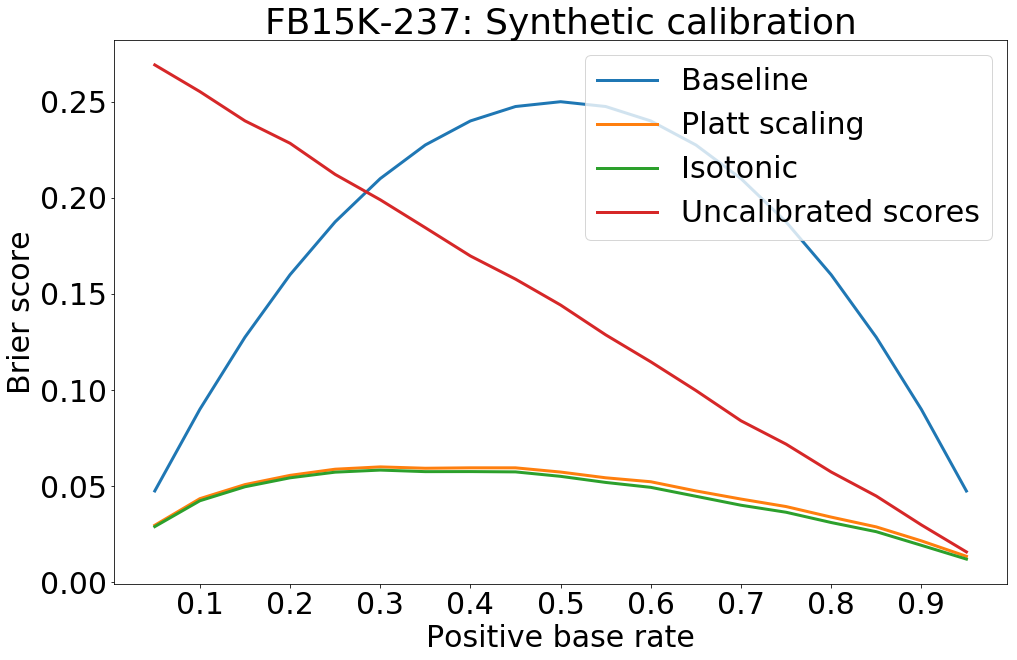

In [49]:
plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 30, 'axes.titlesize': 36})
plt.plot(bs.index, bs.baseline, lw=3, label="Baseline")
plt.plot(bs.index, bs.probas_pos, lw=3, label="Platt scaling")
plt.plot(bs.index, bs.probas_pos_iso, lw=3, label="Isotonic")
plt.plot(bs.index, bs.scores, lw=3, label="Uncalibrated scores")
plt.xlabel("Positive base rate")
plt.ylabel("Brier score")
plt.legend()
plt.xticks(np.linspace(0.1, 0.9, 9))
plt.title("FB15K-237: Synthetic calibration")

In [25]:
ll = df[(c for c in df.columns if c.startswith('log_loss'))]
ll.columns = [c[len("log_loss_"):] for c in ll.columns]
ll.style.apply(highlight_min, axis=1)

,baseline,probas_pos,probas_pos_iso,probas_pos_sc,scores
0.05,0.198515,0.0944066,0.0896446,0.0937973,1.41648
0.1,0.325083,0.136605,0.129608,0.136654,1.34914
0.15,0.42271,0.16228,0.154091,0.165641,1.26774
0.2,0.500402,0.181551,0.171809,0.188352,1.20288
0.25,0.562335,0.195684,0.184247,0.198421,1.12324
0.3,0.610867,0.203357,0.191542,0.208098,1.04808
0.35,0.647448,0.205644,0.19333,0.217415,0.961069
0.4,0.673012,0.209567,0.19626,0.227599,0.893212
0.45,0.68814,0.213763,0.199213,0.23556,0.837399
0.5,0.693147,0.210058,0.195648,0.224039,0.760621


Text(0.5, 1.0, 'FB15K-237: Synthetic calibration')

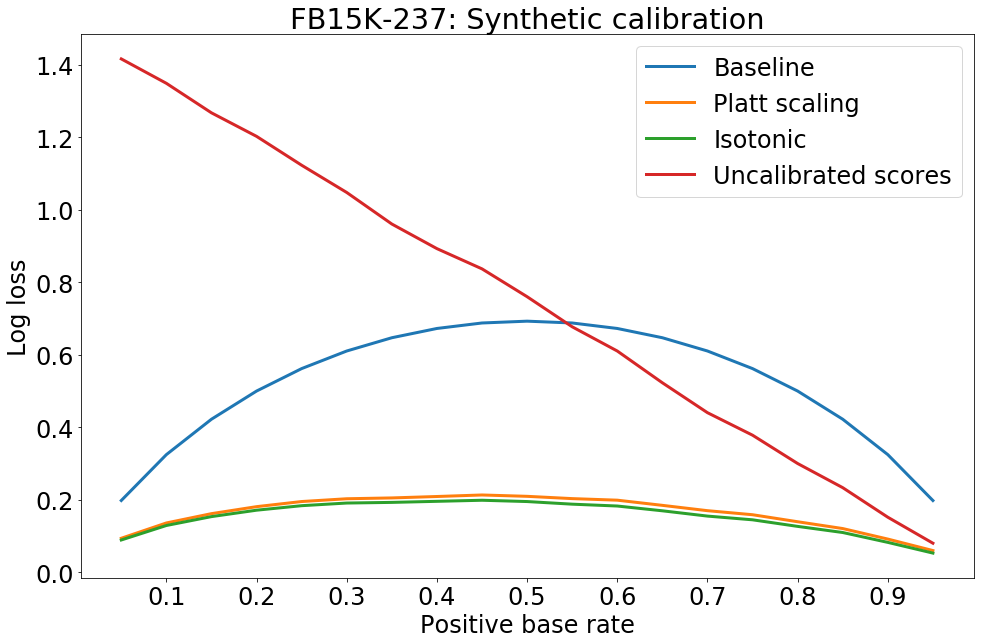

In [46]:
plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 24})
plt.plot(ll.index, ll.baseline, lw=3, label="Baseline")
plt.plot(ll.index, ll.probas_pos, lw=3, label="Platt scaling")
plt.plot(ll.index, ll.probas_pos_iso, lw=3, label="Isotonic")
plt.plot(ll.index, ll.scores, lw=3, label="Uncalibrated scores")
plt.xlabel("Positive base rate")
plt.ylabel("Log loss")
plt.legend()
plt.xticks(np.linspace(0.1, 0.9, 9))
plt.title("FB15K-237: Synthetic calibration")